# EDA 

In [1]:
#Import Libraries

# common DS libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math

# helper libraries
import json
import datetime
import pickle

# CNN model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

# Model evaluation
from sklearn.metrics import mean_squared_error

## Read data

### Police Complaints

In [167]:
def append_to_df(df, path, xlsx=False, sep=','):
    df=pd.concat([
        df, 
        pd.read_excel(path, engine='openpyxl') if xlsx else pd.read_csv(path, sep=sep, encoding='latin-1')
    ])
    
    return df

def read_complaints():
    df_complaints=pd.read_csv('./Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', sep=',')#[['Date', 'HomeTeam', 'AwayTeam']]
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/Contact_Gennaio_Giugno_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx', xlsx=True)
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep=';')

    df_complaints["Data"]=pd.to_datetime(df_complaints['Data'], utc=True).astype('datetime64[ns]')
    df_complaints["Ora"]=pd.to_datetime(df_complaints['Ora'].astype(str), utc=True, format='%H.%M').values.astype('<M8[h]')
    return df_complaints.sort_values("Data", ascending=True) 

df_complaints=read_complaints()
df_complaints=df_complaints[df_complaints["Sottocategoria Criminologica"]=="Rumori molesti"]
df_complaints

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
560,Convivenza Civile,Rumori molesti,1.0,MISERICORDIA/(VIA) ...,NaN,2016-01-03,NaT
560,Convivenza Civile,Rumori molesti,1.0,MISERICORDIA/(VIA) ...,NaN,2016-01-03,NaT
540,Convivenza Civile,Rumori molesti,9.0,NIZZA/(VIA) ...,NaN,2016-01-15,NaT
540,Convivenza Civile,Rumori molesti,9.0,NIZZA/(VIA) ...,NaN,2016-01-15,NaT
541,Convivenza Civile,Rumori molesti,7.0,CIGNA/FRANCESCO (LARGO) ...,NaN,2016-01-16,NaT
...,...,...,...,...,...,...,...
437,Convivenza Civile,Rumori molesti,7.0,REGGIO/(VIA) ...,NaN,2019-11-28,NaT
447,Convivenza Civile,Rumori molesti,4.0,BAGETTI/PIETRO (VIA) ...,NaN,2019-12-02,NaT
413,Convivenza Civile,Rumori molesti,8.0,S. ANSELMO/(VIA) ...,NaN,2019-12-09,1900-01-01 07:00:00
441,Convivenza Civile,Rumori molesti,3.0,COL DI LANA/(VIA) ...,NaN,2019-12-13,1900-01-01 12:00:00


#### Aggregate complaints per day

In [183]:
df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")
df_complaints_day_district8=df_complaints.loc[df_complaints['Circoscrizione'] == 8.0].groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")
df_complaints_day

,Data,counts
0,2016-01-03,2
1,2016-01-04,0
2,2016-01-05,0
3,2016-01-06,0
4,2016-01-07,0
...,...,...
1436,2019-12-09,1
1437,2019-12-10,0
1438,2019-12-11,0
1439,2019-12-12,0


#### Aggregate complaints per hour (most entries don't have hour)

In [169]:
df_complaints_hour=df_complaints.groupby(pd.Grouper(key="Ora", freq="H")).size().reset_index(name='counts').sort_values("Ora")
df_complaints_hour

,Ora,counts
0,1900-01-01 07:00:00,5
1,1900-01-01 08:00:00,7
2,1900-01-01 09:00:00,15
3,1900-01-01 10:00:00,19
4,1900-01-01 11:00:00,19
5,1900-01-01 12:00:00,14
6,1900-01-01 13:00:00,8
7,1900-01-01 14:00:00,7
8,1900-01-01 15:00:00,2


### Weather from IoT sensors

In [170]:
def obj_col_to_float(df, col):
    df[col] = df[col].astype(str).str.replace(',', '.')
    df[col]=df[col].astype(float)
    
    return df

In [171]:
# C1 = TORINO GIARDINI REALI, Rain level about 10 minutes - Millimeters;;;
df_rain = pd.read_csv('./Data/weather/weather_rain.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'rain_mm'})
# C1 = TORINO GIARDINI REALI, Wind speed (scalar) - Meters per second;;
df_wind_speed = pd.read_csv('./Data/weather/weather_wind_speed.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'wind_speed_ms'})
# C1 = TORINO GIARDINI REALI, Wind speed (gust) - Meters per second;;
df_wind_gust = pd.read_csv('./Data/weather/weather_wind_gust.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'wind_gust_ms'})
# C1 = TORINO GIARDINI REALI, Snow depth - Meters;;;
# C2 = TORINO GIARDINI REALI, Air temperature - Degrees Celsius;;;
df_snow_temperature = pd.read_csv('./Data/weather/weather_snow_temperature.csv', sep=';')[['Date', 'Hour', 'C1', 'C2']].rename(columns={'C1':'snow_m', 'C2': 'temperature_c'})


df_weather=pd.merge(df_rain, df_wind_speed, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')
df_weather=pd.merge(df_weather, df_wind_gust, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')
df_weather=pd.merge(df_weather, df_snow_temperature, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')

df_weather["Date"]=pd.to_datetime(df_weather['Date'], utc=True).astype('datetime64[ns]')
df_weather=obj_col_to_float(df_weather, "rain_mm")
df_weather=obj_col_to_float(df_weather, "wind_speed_ms")
df_weather=obj_col_to_float(df_weather, "wind_gust_ms")
df_weather=obj_col_to_float(df_weather, "snow_m")
df_weather=obj_col_to_float(df_weather, "temperature_c")

df_weather

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,2016-01-06,00:00,NaN,NaN,NaN,NaN,NaN
1,2016-01-06,00:10,0.0,0.6,NaN,NaN,NaN
2,2016-01-06,00:20,0.0,0.7,NaN,NaN,NaN
3,2016-01-06,00:30,0.0,0.8,NaN,-0.02,14.2
4,2016-01-06,00:40,0.0,0.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...
266107,2021-06-22,23:10,0.0,NaN,NaN,NaN,NaN
266108,2021-06-22,23:20,0.0,NaN,NaN,NaN,NaN
266109,2021-06-22,23:30,0.0,NaN,NaN,0.35,16.9
266110,2021-06-22,23:40,0.4,NaN,NaN,NaN,NaN


#### Generate aggregated values per day

In [172]:
df_weather_day=df_weather.groupby("Date", dropna=True).agg({
    'rain_mm': 'mean', 
    'wind_speed_ms': 'mean',
    'wind_gust_ms': 'mean',
    'snow_m': 'mean',
    'temperature_c': 'mean'
}) 

df_weather_day

,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
Date,,,,,
2016-01-06,0.000000,0.731469,2.126087,0.017872,17.736170
2016-01-07,0.000000,0.260839,1.404348,0.031489,24.648936
2016-01-08,0.001399,0.470629,2.226087,-0.005106,24.785106
2016-01-09,0.000000,0.481119,1.565217,-0.006809,24.536170
2016-01-10,0.000000,0.467133,1.652174,0.025532,16.946809
...,...,...,...,...,...
2021-12-02,0.000000,NaN,NaN,-0.000213,3.472340
2021-12-03,0.000000,NaN,NaN,-0.026596,10.127660
2021-12-04,0.012587,NaN,NaN,0.018936,10.714894


#### Generate aggregated values per hour

In [173]:
df_weather_hour=df_weather

df_weather_hour["Hour"]=pd.to_datetime(df_weather['Hour'].astype(str), utc=True, format='%H:%M').values.astype('<M8[h]')

df_weather_hour=df_weather.groupby("Hour", dropna=True).agg({
    'rain_mm': 'mean', 
    'wind_speed_ms': 'mean',
    'wind_gust_ms': 'mean',
    'snow_m': 'mean',
    'temperature_c': 'mean'
}) 

df_weather_hour=df_weather_hour.reset_index()

df_weather_hour

,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,1900-01-01 00:00:00,0.015665,0.287866,NaN,0.045073,11.895652
1,1900-01-01 01:00:00,0.012034,0.283394,1.226715,0.043985,11.592841
2,1900-01-01 02:00:00,0.014851,0.266577,1.238378,0.046364,11.239292
3,1900-01-01 03:00:00,0.012147,0.267327,1.200901,0.048031,10.902588
4,1900-01-01 04:00:00,0.013539,0.263483,1.233514,0.049485,10.610879
5,1900-01-01 05:00:00,0.015122,0.266547,1.190270,0.047208,10.369894
6,1900-01-01 06:00:00,0.014531,0.271502,1.203243,0.053011,10.192988
7,1900-01-01 07:00:00,0.013272,0.345526,1.221982,0.056872,10.416388
8,1900-01-01 08:00:00,0.015408,0.480601,1.444505,0.054700,11.732749
9,1900-01-01 09:00:00,0.012992,0.664602,1.726126,0.048637,13.479265


### Holidays

In [174]:
df_holidays=None 

for year in range (2016, 2022): 
    with open('./Data/holidays/{}.json'.format(year)) as f:
       data = json.load(f)

    curr = pd.json_normalize(data, ["response", 'holidays'])
    if df_holidays is None:
        df_holidays = curr
    else:
        df_holidays=pd.concat([df_holidays, curr])
  
df_holidays['date.iso'] = pd.to_datetime(df_holidays['date.iso'], utc=True).astype('datetime64[ns]')
print(df_holidays.shape)

df_holidays=df_holidays[["name", "description", "type", "date.iso", "locations", "states"]]
df_holidays.head()

(144, 19)


,name,description,type,date.iso,locations,states
0,New Year's Day,New Year’s Day is celebrated in Italy on Janua...,[National holiday],2016-01-01 00:00:00,All,All
1,Epiphany,Epiphany is a national holiday in Italy celebr...,[National holiday],2016-01-06 00:00:00,All,All
2,March Equinox,March Equinox in Italy (Rome),[Season],2016-03-20 04:30:04,All,All
3,Good Friday,Good Friday is part of the Holy Week of Easter...,[Observance],2016-03-25 00:00:00,All,All
4,Easter Sunday,Easter Day is a public holiday that is celebra...,[Observance],2016-03-27 00:00:00,All,All


### Football games

In [175]:
df_football=None 

for year in range (2015, 2021): 
    curr = pd.read_csv('./Data/football/series_a/{}.csv'.format(year), sep=',')[['Date', 'HomeTeam', 'AwayTeam']]
    if df_football is None:
        df_football = curr
    else:
        df_football=pd.concat([df_football, curr])

df_football["Date"]=pd.to_datetime(df_football['Date'], utc=True).astype('datetime64[ns]')

# Filter by games related at fc torino
df_football=df_football[df_football['HomeTeam']=='Torino']
df_football

,Date,HomeTeam,AwayTeam
18,2015-08-30,Torino,Fiorentina
39,2015-09-20,Torino,Sampdoria
56,2015-09-27,Torino,Palermo
71,2015-10-17,Torino,Milan
97,2015-10-28,Torino,Genoa
...,...,...,...
307,2021-04-18,Torino,Roma
327,2021-04-26,Torino,Napoli
338,2021-03-05,Torino,Parma
357,2021-12-05,Torino,Milan


## Correlation Analysis

### Anomaly correlations

In [176]:
base = './Data/noise_data/csv_format'

In [177]:
def saving_dfs_as_binary_files(base):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base)

In [178]:
sensors=["C1", "C2", "C3", "C4", "C5"]
# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base+'/'+"df_raw", "rb" ))

    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')
    
    df['C1_temp'] = pow(10, df['C1']/10)
    df['C2_temp'] = pow(10, df['C2']/10)
    df['C3_temp'] = pow(10, df['C3']/10)
    df['C4_temp'] = pow(10, df['C4']/10)
    df['C5_temp'] = pow(10, df['C5']/10)
    
    # e se tiver valores nulos??
    df['C_avg'] = df[['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']].sum(axis = 1).div(5)
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
df = get_sensors_data(sensors)
df

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
date,,,,,,,,,,
2016-06-01 00:00:00,2016,6,1,0,61.1,58.8,63.7,60.4,60.2,61.162532
2016-06-01 01:00:00,2016,6,1,1,57.2,56.1,60.4,57.7,58.4,58.207715
2016-06-01 02:00:00,2016,6,1,2,52.5,53.4,52.9,56.7,56.5,54.788571
2016-06-01 03:00:00,2016,6,1,3,50.6,46.6,45.7,47.9,55.6,50.951102
2016-06-01 04:00:00,2016,6,1,4,47.4,46.2,45.1,45.8,56.8,51.110268
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,62.2,59.8,60.3,NaN,NaN,58.675970
2019-12-31 20:00:00,2019,12,31,20,59.4,59.7,55.9,NaN,NaN,56.421207
2019-12-31 21:00:00,2019,12,31,21,59.2,61.0,56.0,NaN,NaN,56.970194


In [179]:
def outlier_detection_using_z_score(df, t=2):
    # t - threshold - number of standard deviation
    mean = np.mean(df.iloc[:, 0])
    std = np.std(df.iloc[:, 0])
    
    # não fazemos abs((i-mean)/std) porque só nos interessa os que estão acima da média
    df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
    df['is_outlier'] = [1 if x>t else 0 for x in df.z_score.values ]
    
    df['out'] = df['C1'] * df['is_outlier']
    df['out'] = [None if x==0 else x for x in df.out.values]

    df = df.reset_index()
    
    return df
    
    
df_out = outlier_detection_using_z_score(df[['C1']], t=1)
df_out

<ipython-input-179-ea1a03bc649d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
<ipython-input-179-ea1a03bc649d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_outlier'] = [1 if x>t else 0 for x in df.z_score.values ]
<ipython-input-179-ea1a03bc649d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,date,C1,z_score,is_outlier,out
0,2016-06-01 00:00:00,61.1,0.291701,0,NaN
1,2016-06-01 01:00:00,57.2,-0.401050,0,NaN
2,2016-06-01 02:00:00,52.5,-1.235904,0,NaN
3,2016-06-01 03:00:00,50.6,-1.573398,0,NaN
4,2016-06-01 04:00:00,47.4,-2.141809,0,NaN
...,...,...,...,...,...
31411,2019-12-31 19:00:00,62.2,0.487092,0,NaN
31412,2019-12-31 20:00:00,59.4,-0.010268,0,NaN
31413,2019-12-31 21:00:00,59.2,-0.045793,0,NaN
31414,2019-12-31 22:00:00,57.0,-0.436576,0,NaN


### Aggregate noise peaks per day

In [180]:
df_out_max_per_day=df_out.groupby(pd.Grouper(key="date", freq = 'D')).agg({'C1': 'max'})

df_outlier_day = (df_out.set_index('date')
               .groupby([pd.Grouper(freq = 'D'),'is_outlier'])
               .size()
               .unstack(fill_value=0))

df_max_peaks_day=pd.merge(df_out_max_per_day, df_outlier_day, left_on="date", right_on="date")[[1, "C1"]].rename(columns={1: "noise_peaks", 'C1':'max_day_peak'})

df_max_peaks_day

,noise_peaks,max_day_peak
date,,
2016-06-01,3,69.1
2016-06-02,3,70.8
2016-06-03,4,68.4
2016-06-04,8,71.4
2016-06-05,5,69.9
...,...,...
2019-12-27,1,65.1
2019-12-28,2,69.4
2019-12-29,3,67.4


### Aggregate noise peaks per hour

<AxesSubplot:xlabel='date'>

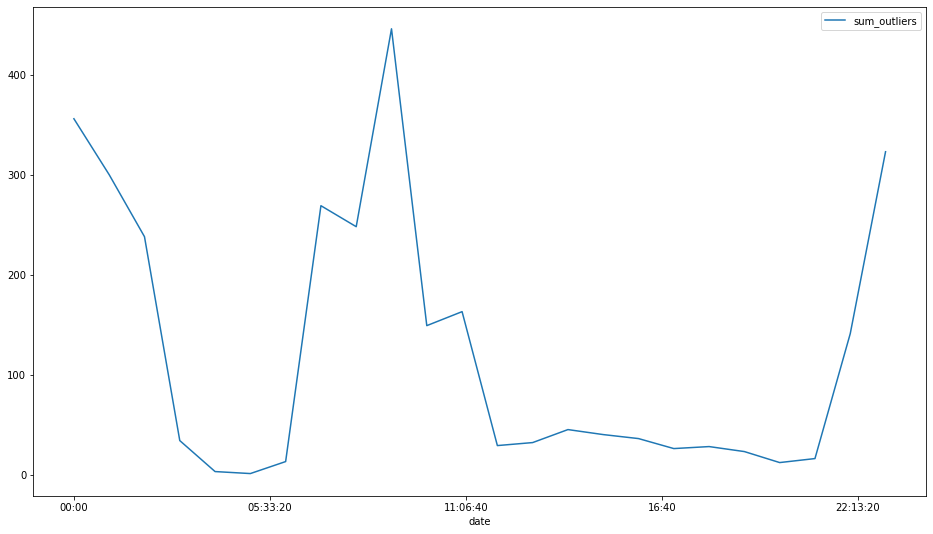

In [181]:
df_outlier_hour = df_out.groupby(df_out.date.dt.time).agg({"is_outlier": "sum"}).rename(columns={"is_outlier": "sum_outliers"})
df_outlier_hour
#df_max_peaks_hour=pd.merge(df_out_max_per_hour, df_outlier_hour, left_on="date", right_on="date")[[True, "C1"]].rename(columns={True: "noise_peaks", 'C1':'max_day_peak'})

df_outlier_hour.plot(figsize=(16,9))

### Merge complaints and noise peaks for district 8 (san salvario)

<AxesSubplot:xlabel='Data'>

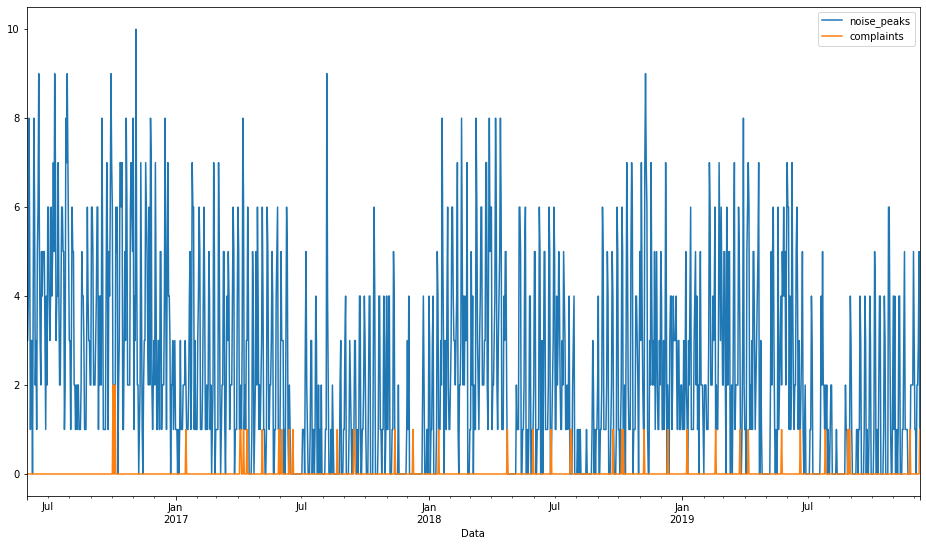

In [191]:
# Merge dfs
df_merged=pd.merge(df_complaints_day, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')

df_comp_peaks_day=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})

df_merged=pd.merge(df_complaints_day_district8, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')
df_comp_peaks_day_district8=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})

df_comp_peaks_day_district8.plot(x="Data", y=["noise_peaks", "complaints"], figsize=(16,9))

## Relation between noise peaks (anomalies) and noise complaints per day

<AxesSubplot:>

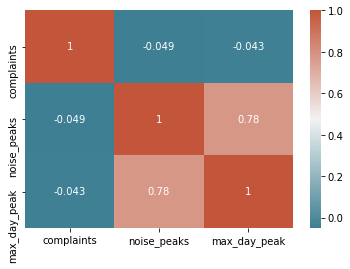

In [192]:
# calculate correlation matrix
corr = df_comp_peaks_day_district8.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [193]:
df_peaks_comps=df_comp_peaks_day_district8.groupby("noise_peaks").agg({'complaints': 'sum'}) 

df_peaks_comps

,complaints
noise_peaks,
0,11
1,15
2,6
3,4
4,1
5,0
6,3
7,1
8,0


<AxesSubplot:title={'center':'Noise peaks vs complaints per day'}, xlabel='Number of noise peaks', ylabel='Number of complaints'>

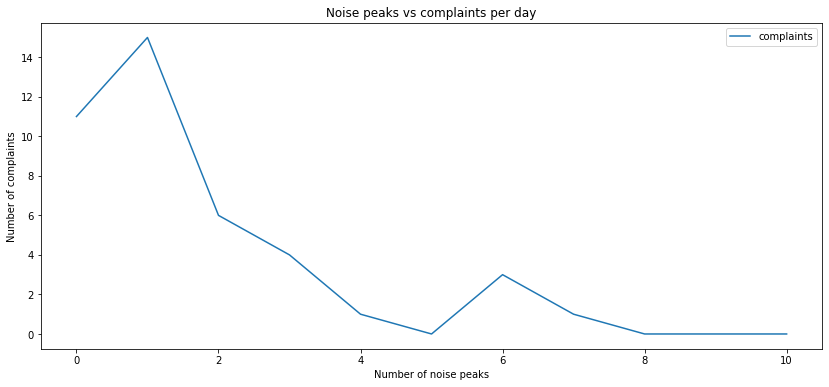

In [195]:
df_peaks_comps.plot(figsize=(14,6), ylabel="Number of complaints", xlabel="Number of noise peaks", title="Noise peaks vs complaints per day")

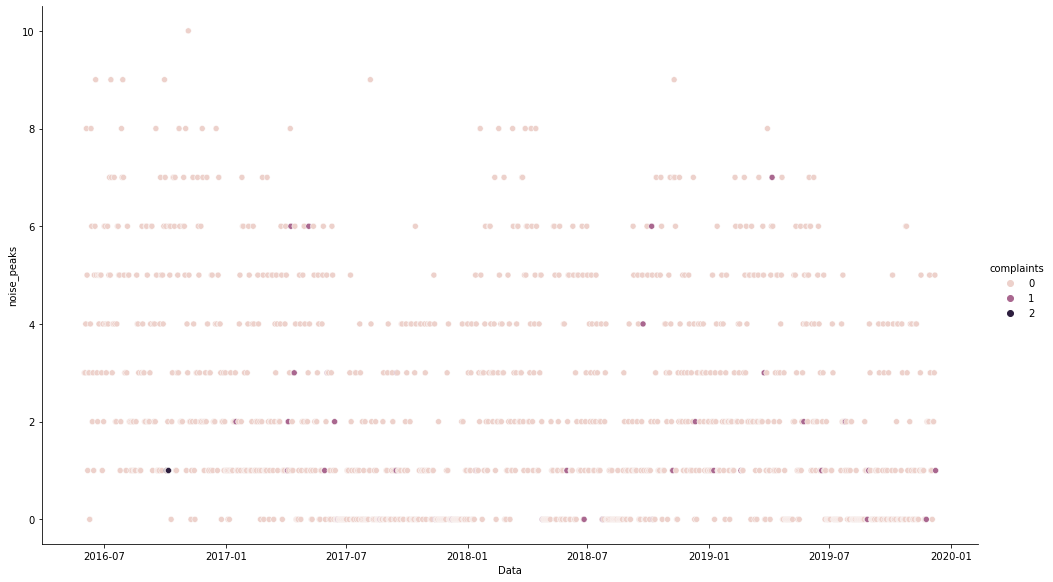

In [199]:
sns.relplot(x="Data", y="noise_peaks", hue="complaints", data=df_comp_peaks_day_district8,  height=8, aspect=1.7)

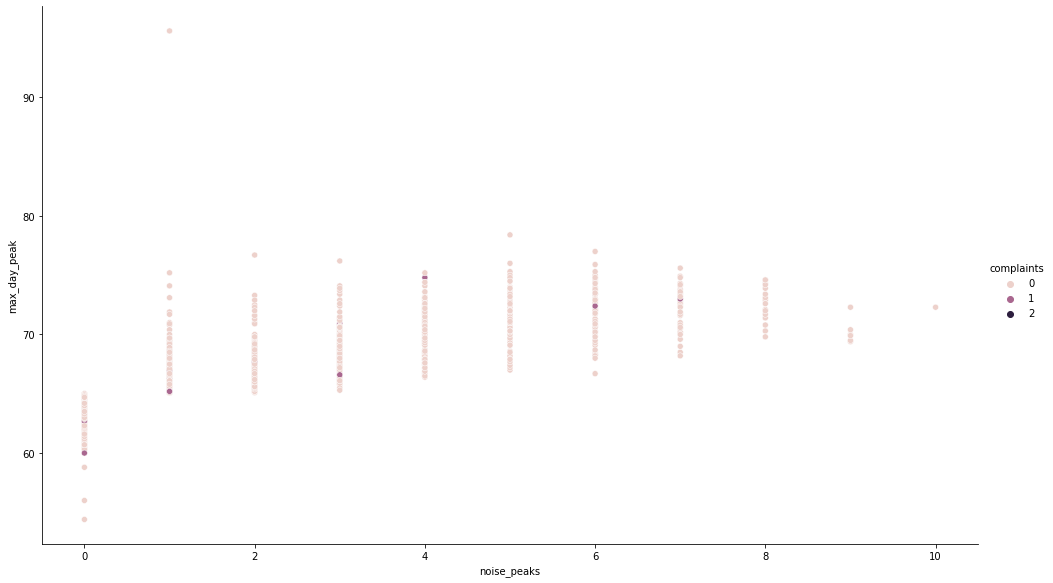

In [198]:
sns.relplot(x="noise_peaks", y="max_day_peak",  hue="complaints", data=df_comp_peaks_day_district8,  height=8, aspect=1.7)

When we don't have any peaks, the maximum day peak is logically small. When we have peaks then we have a maximum day noise peak that is larger.  


However, having larger day noise peaks doesn't necessaraly mean more complaints, neither does having more noise peaks in a day.

## Weather

In [200]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_weather_day, left_on=["Data"], right_on=["Date"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

df_merged

,Data,complaints,noise_peaks,max_day_peak,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,2016-06-01,0.0,3.0,69.1,NaN,NaN,NaN,NaN,NaN
1,2016-06-02,0.0,3.0,70.8,NaN,NaN,NaN,NaN,NaN
2,2016-06-03,0.0,4.0,68.4,NaN,NaN,NaN,NaN,NaN
3,2016-06-04,4.0,8.0,71.4,NaN,NaN,NaN,NaN,NaN
4,2016-06-05,0.0,5.0,69.9,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1286,2019-12-09,1.0,1.0,65.2,0.000000,NaN,NaN,0.087021,20.344681
1287,2019-12-10,0.0,0.0,64.7,0.000000,NaN,NaN,0.022222,13.648936
1288,2019-12-11,0.0,1.0,70.7,0.001399,NaN,NaN,0.010000,7.517021
1289,2019-12-12,0.0,2.0,66.0,0.000000,NaN,NaN,-0.007447,2.393617


### Overall correlation

<AxesSubplot:>

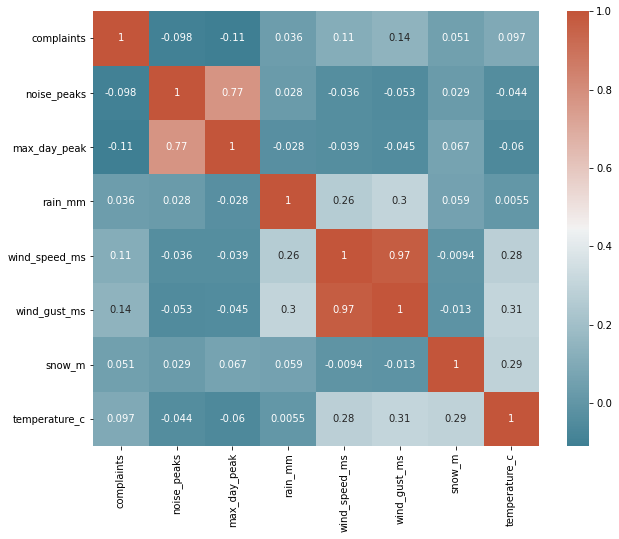

In [201]:
# calculate correlation matrix
corr = df_merged.corr()# plot the heatmap
plt.figure(figsize = (10,8))

sns.heatmap(
    corr, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns, 
    annot=True, 
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)

### Wind vs Noise Complaints vs Noise Peaks

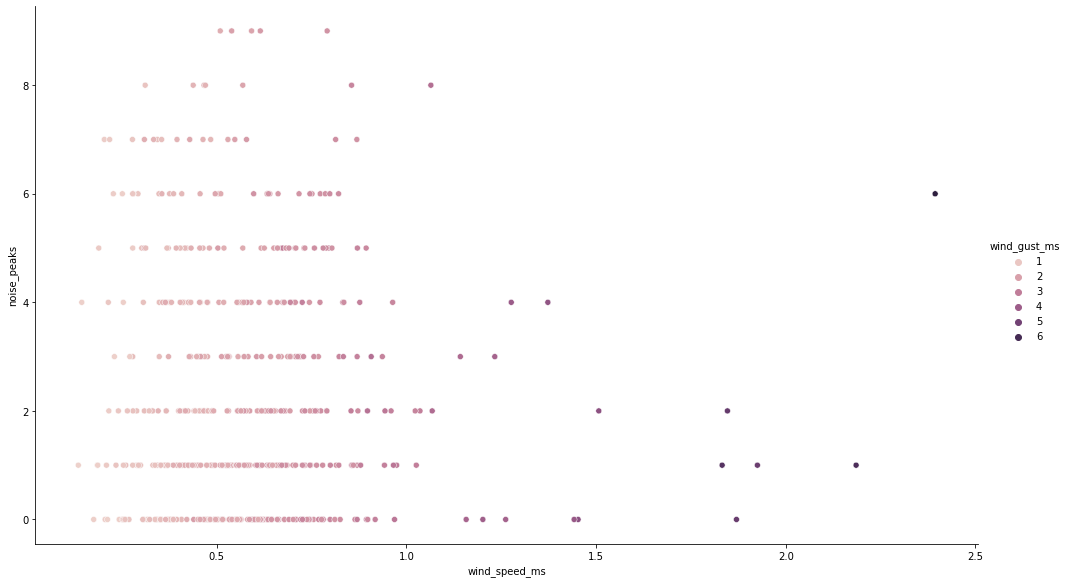

In [202]:
sns.relplot(x="wind_speed_ms", y="noise_peaks", hue="wind_gust_ms", data=df_merged, height=8, aspect=1.7);

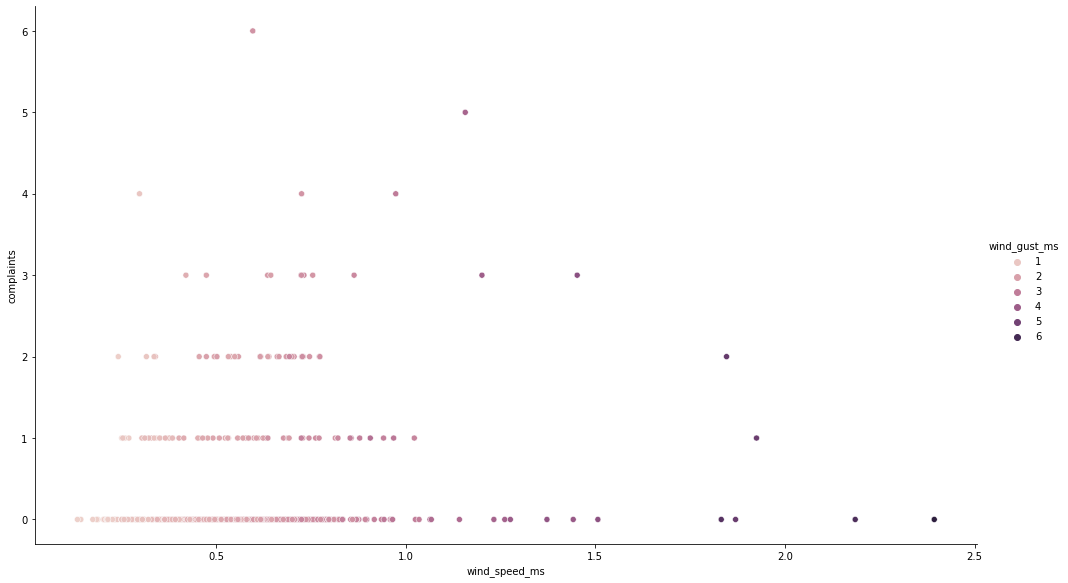

In [203]:
sns.relplot(x="wind_speed_ms", y="complaints", hue="wind_gust_ms", data=df_merged, height=8, aspect=1.7);

We can verify that whenever we have a larger wind speed then we have less noise peaks. Therefore, this can lead to the conclusion that when there is a larger wind speed then we will have less people around each other in the roads/restaurents/etc. and ultemately less noise.

### Temperature/Snow vs Noise Complaints vs Noise Peaks

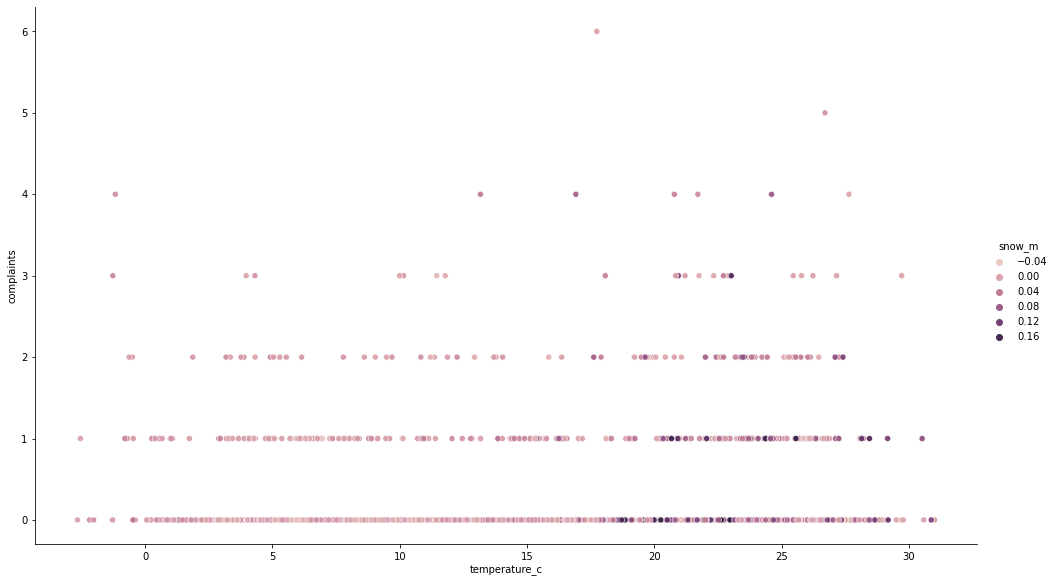

In [204]:
sns.relplot(x="temperature_c", y="complaints", hue="snow_m", data=df_merged, height=8, aspect=1.7);

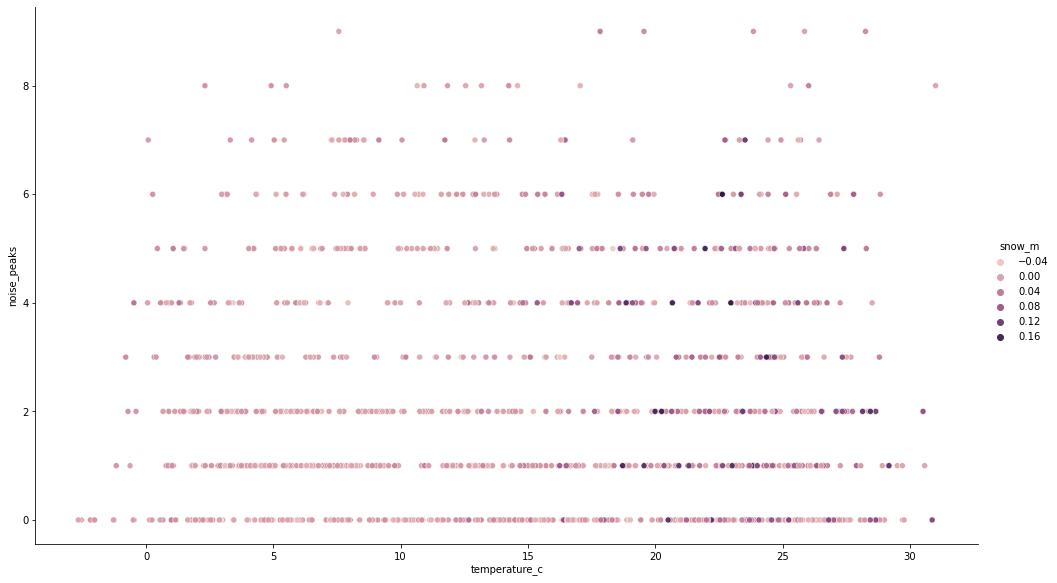

In [205]:
sns.relplot(x="temperature_c", y="noise_peaks", hue="snow_m", data=df_merged, height=8, aspect=1.7);

### Rain vs Noise Complaints vs Noise Peaks

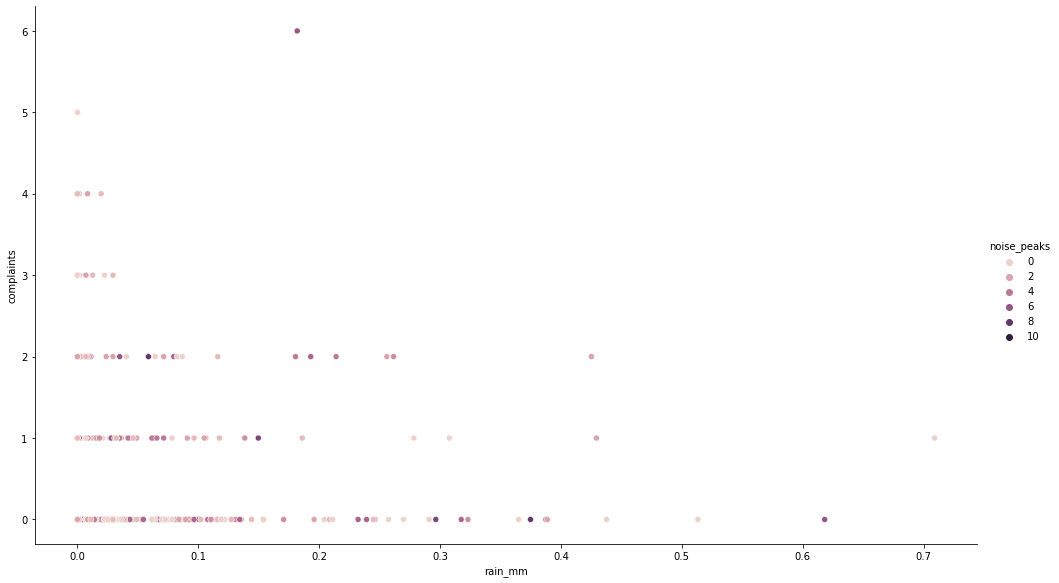

In [206]:
sns.relplot(x="rain_mm", y="complaints", hue="noise_peaks", data=df_merged, height=8, aspect=1.7);

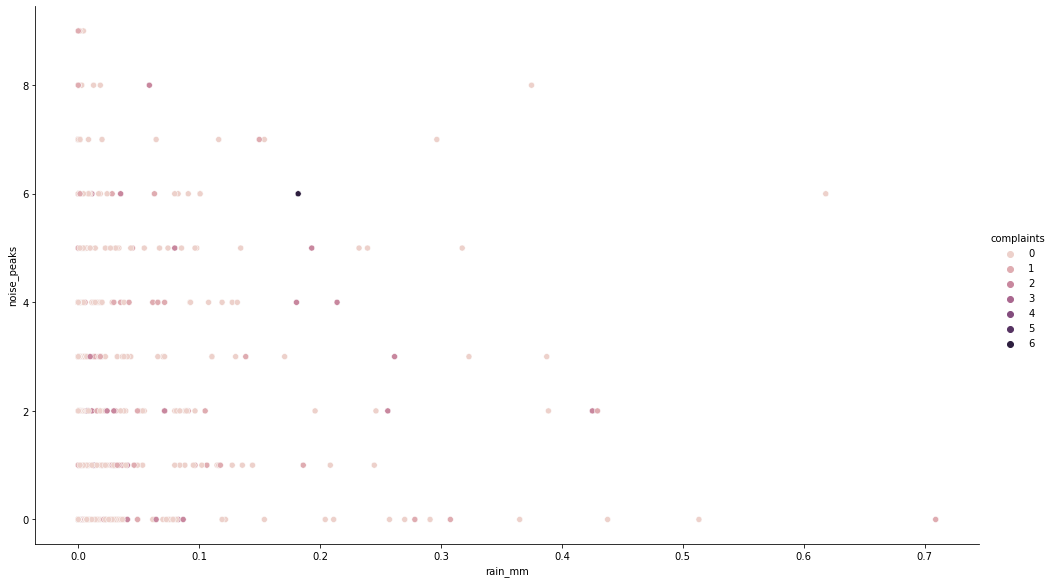

In [207]:
sns.relplot(x="rain_mm", y="noise_peaks", hue="complaints", data=df_merged, height=8, aspect=1.7);

### Rain vs wind speed vs noise peaks

<AxesSubplot:>

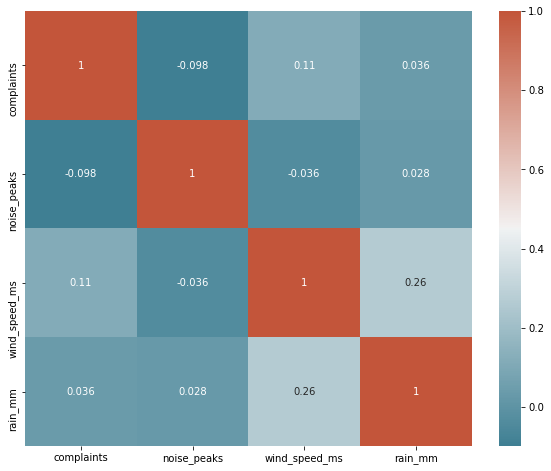

In [208]:
# calculate correlation matrix
corr = df_merged[["complaints", "noise_peaks", "wind_speed_ms", "rain_mm"]].corr()# plot the heatmap
plt.figure(figsize = (10,8))

sns.heatmap(
    corr, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns, 
    annot=True, 
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)

We can verify that whenever we have more rain then we have less noise peaks. Therefore, this can lead to the conclusion that when there is more rain then we will have less people around each other in the roads/restaurents/etc. and ultemately less noise.

### Analysis per hour

In [164]:
# Merge dfs
df_merged=pd.merge(df_weather_hour, df_complaints_hour, left_on=["Hour"], right_on=["Ora"], how='outer')
df_merged["Hour"]=df_merged.Hour.dt.time
df_merged=pd.merge(df_merged, df_outlier_hour, left_on=["Hour"], right_on=["date"], how='outer')

#df_merged=df_merged[df_merged["counts"].notnull()]

df_peaks_comps_hour=df_merged
del df_peaks_comps_hour["Ora"]

df_peaks_comps_hour

,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c,counts,sum_outliers
0,00:00:00,0.015665,0.287866,NaN,0.045073,11.895652,NaN,356
1,01:00:00,0.012034,0.283394,1.226715,0.043985,11.592841,NaN,300
2,02:00:00,0.014851,0.266577,1.238378,0.046364,11.239292,NaN,238
3,03:00:00,0.012147,0.267327,1.200901,0.048031,10.902588,NaN,34
4,04:00:00,0.013539,0.263483,1.233514,0.049485,10.610879,NaN,3
5,05:00:00,0.015122,0.266547,1.190270,0.047208,10.369894,NaN,1
6,06:00:00,0.014531,0.271502,1.203243,0.053011,10.192988,NaN,13
7,07:00:00,0.013272,0.345526,1.221982,0.056872,10.416388,1.0,269
8,08:00:00,0.015408,0.480601,1.444505,0.054700,11.732749,1.0,248
9,09:00:00,0.012992,0.664602,1.726126,0.048637,13.479265,1.0,446


<AxesSubplot:>

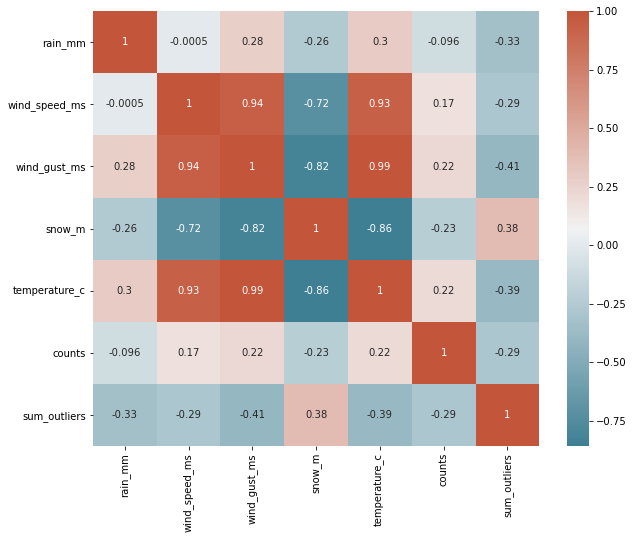

In [166]:
# calculate correlation matrix
corr = df_peaks_comps_hour.corr()# plot the heatmap
plt.figure(figsize = (10,8))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### Weekends vs noise peaks

In [209]:
# Assign bool var
df_comp_peaks_day['IsWeekend'] = df_comp_peaks_day.apply(lambda row: True if row.Data.weekday() > 4 else False, axis=1)

# project values
df_weekend=df_comp_peaks_day[["Data", "complaints", "noise_peaks", "IsWeekend"]]
df_weekend

,Data,complaints,noise_peaks,IsWeekend
0,2016-06-01,0,3,False
1,2016-06-02,0,3,False
2,2016-06-03,0,4,False
3,2016-06-04,4,8,True
4,2016-06-05,0,5,True
...,...,...,...,...
1286,2019-12-09,1,1,False
1287,2019-12-10,0,0,False
1288,2019-12-11,0,1,False
1289,2019-12-12,0,2,False


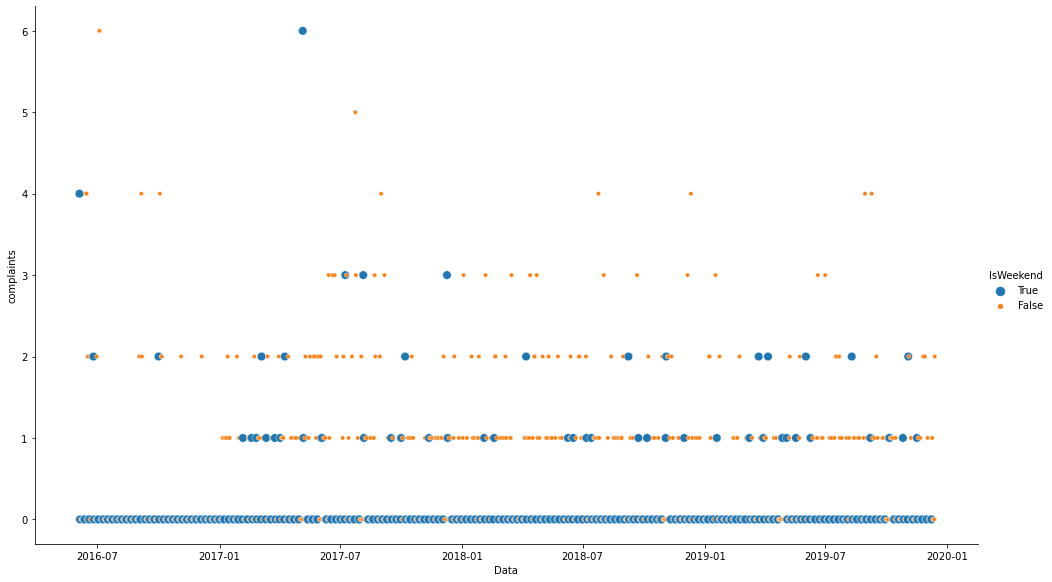

In [210]:
sns.relplot(x="Data", y="complaints", hue="IsWeekend", hue_order=[True, False], size_order=[True, False], size="IsWeekend", data=df_weekend, height=8, aspect=1.7);

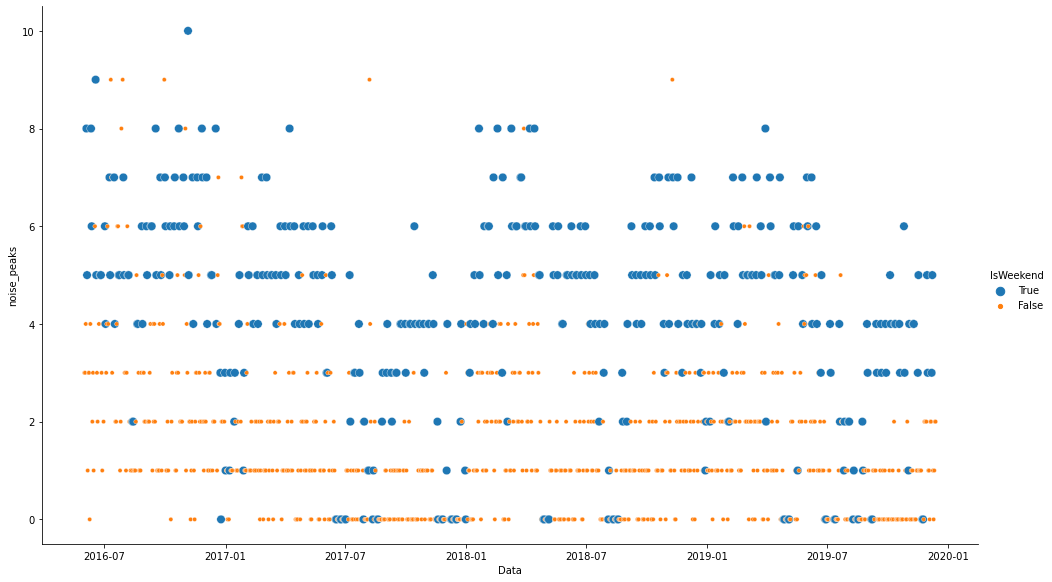

In [211]:
sns.relplot(x="Data", y="noise_peaks", hue="IsWeekend", hue_order=[True, False], size_order=[True, False], size="IsWeekend", data=df_weekend, height=8, aspect=1.7);

### Holidays vs noise peaks

In [212]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_holidays, left_on=["Data"], right_on=["date.iso"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

# Assign bool var
df_merged['IsHoliday'] = df_merged.apply(lambda row: False if pd.isnull(row['type'])  else True, axis=1)

# project values
df_metrics_holidays_day=df_merged[["Data", "complaints", "noise_peaks", "IsHoliday"]]
df_metrics_holidays_day

,Data,complaints,noise_peaks,IsHoliday
0,2016-06-01,0.0,3.0,False
1,2016-06-02,0.0,3.0,True
2,2016-06-03,0.0,4.0,False
3,2016-06-04,4.0,8.0,False
4,2016-06-05,0.0,5.0,False
...,...,...,...,...
1293,2019-12-09,1.0,1.0,False
1294,2019-12-10,0.0,0.0,False
1295,2019-12-11,0.0,1.0,False
1296,2019-12-12,0.0,2.0,False


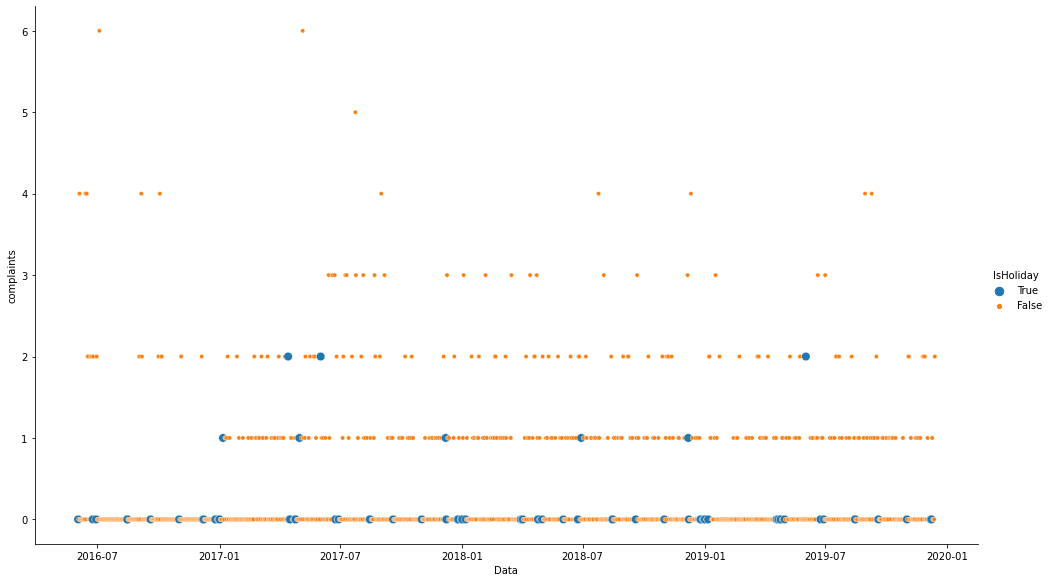

In [213]:
sns.relplot(x="Data", y="complaints", hue="IsHoliday", hue_order=[True, False], size_order=[True, False], size="IsHoliday", data=df_metrics_holidays_day, height=8, aspect=1.7);

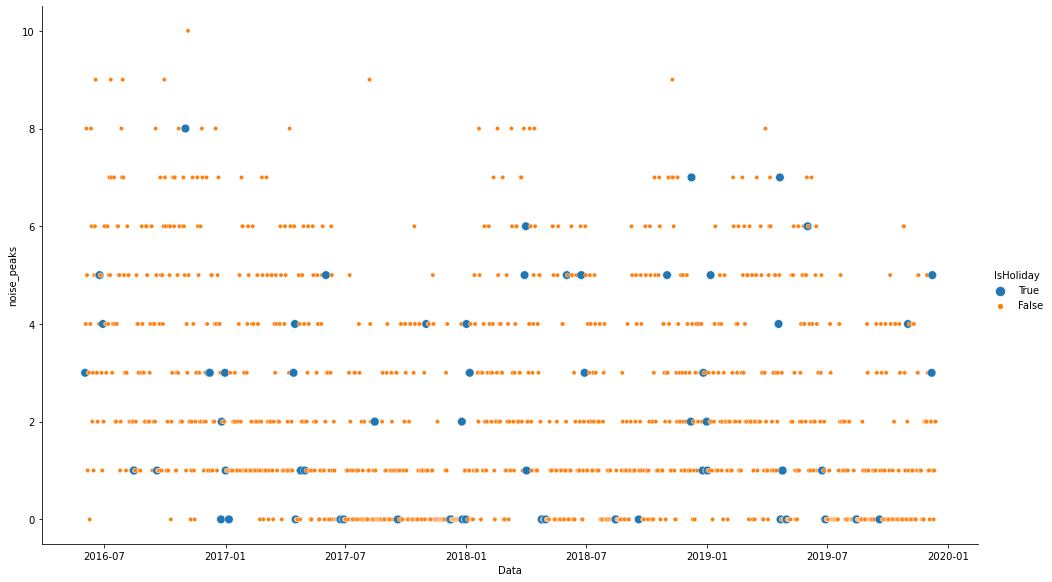

In [214]:
sns.relplot(x="Data", y="noise_peaks", hue="IsHoliday", hue_order=[True, False], size_order=[True, False], size="IsHoliday", data=df_metrics_holidays_day, height=8, aspect=1.7);

### Football vs noise peaks

In [215]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_football, left_on=["Data"], right_on=["Date"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

# Assign bool var
df_merged['IsFootball'] = df_merged.apply(lambda row: False if pd.isnull(row['HomeTeam'])  else True, axis=1)

# project values
df_metrics_football_day=df_merged[["Data", "complaints", "noise_peaks", "IsFootball"]]
df_metrics_football_day

,Data,complaints,noise_peaks,IsFootball
0,2016-06-01,0.0,3.0,False
1,2016-06-02,0.0,3.0,False
2,2016-06-03,0.0,4.0,True
3,2016-06-04,4.0,8.0,False
4,2016-06-05,0.0,5.0,False
...,...,...,...,...
1286,2019-12-09,1.0,1.0,False
1287,2019-12-10,0.0,0.0,False
1288,2019-12-11,0.0,1.0,False
1289,2019-12-12,0.0,2.0,False


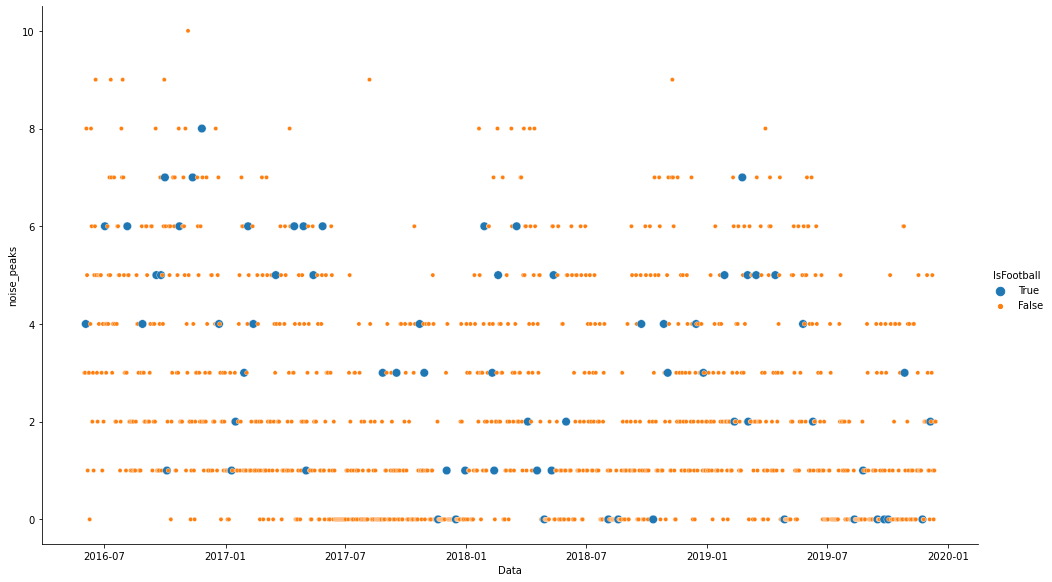

In [216]:
sns.relplot(x="Data", y="noise_peaks", hue="IsFootball", hue_order=[True, False], size_order=[True, False], size="IsFootball", data=df_metrics_football_day, height=8, aspect=1.7);

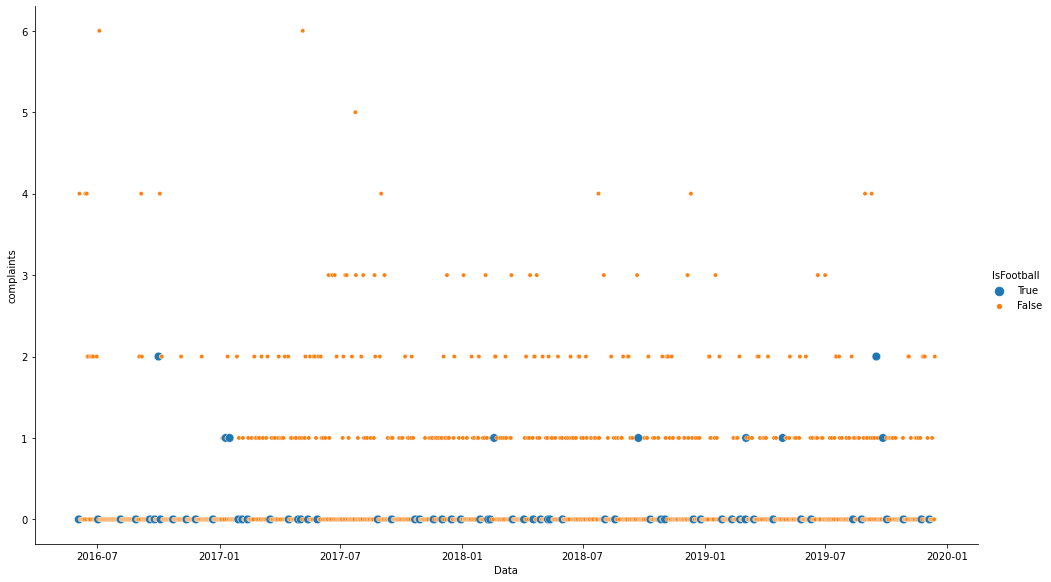

In [217]:
sns.relplot(x="Data", y="complaints", hue="IsFootball", hue_order=[True, False], size_order=[True, False], size="IsFootball", data=df_metrics_football_day, height=8, aspect=1.7);

## Combine weekends, holidays, football games into leisure score

In [218]:
def generate_row_leisure_score(row):
    count=0
    if row.IsHoliday:
        count+=1
        
    if row.IsFootball:
        count+=1
        
    if row.IsWeekend:
        count+=1
    
    return count

# Merge dfs
df_merged=pd.merge(df_metrics_holidays_day, df_metrics_football_day, left_on=["Data"], right_on=["Data"], how='outer')
df_merged=pd.merge(df_merged, df_weekend, left_on=["Data"], right_on=["Data"], how='outer')

df_merged=df_merged[df_merged["Data"].notnull()]
df_merged["leisure_score"]=df_merged.apply(lambda row: generate_row_leisure_score(row), axis=1)

df_leisure_day=df_merged[["Data", "complaints", "noise_peaks", "leisure_score"]]
df_leisure_day

,Data,complaints,noise_peaks,leisure_score
0,2016-06-01,0,3,0
1,2016-06-02,0,3,1
2,2016-06-03,0,4,1
3,2016-06-04,4,8,1
4,2016-06-05,0,5,1
...,...,...,...,...
1293,2019-12-09,1,1,0
1294,2019-12-10,0,0,0
1295,2019-12-11,0,1,0
1296,2019-12-12,0,2,0


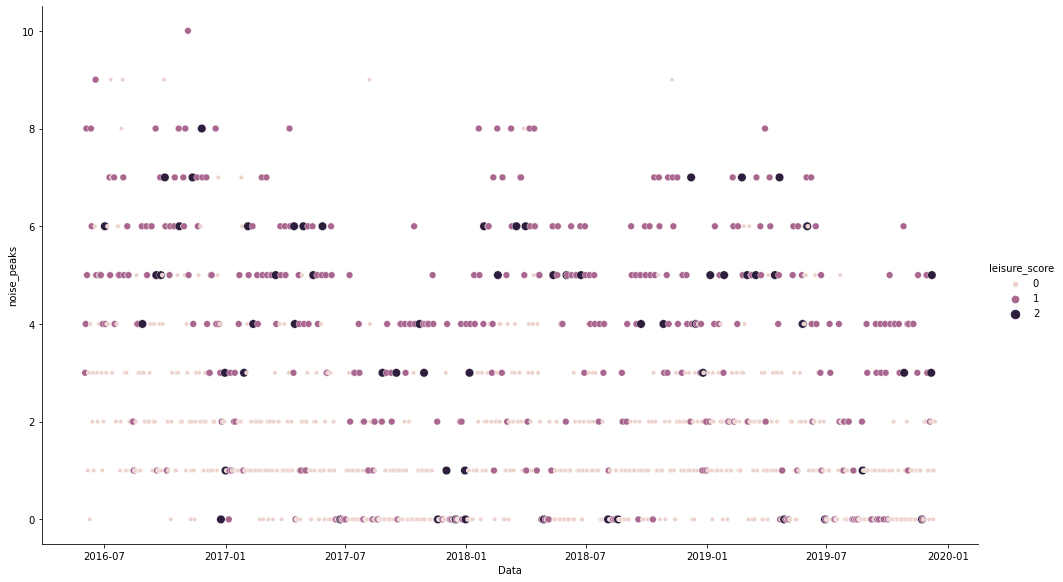

In [219]:
sns.relplot(x="Data", y="noise_peaks", hue="leisure_score", size="leisure_score", data=df_leisure_day, height=8, aspect=1.7);

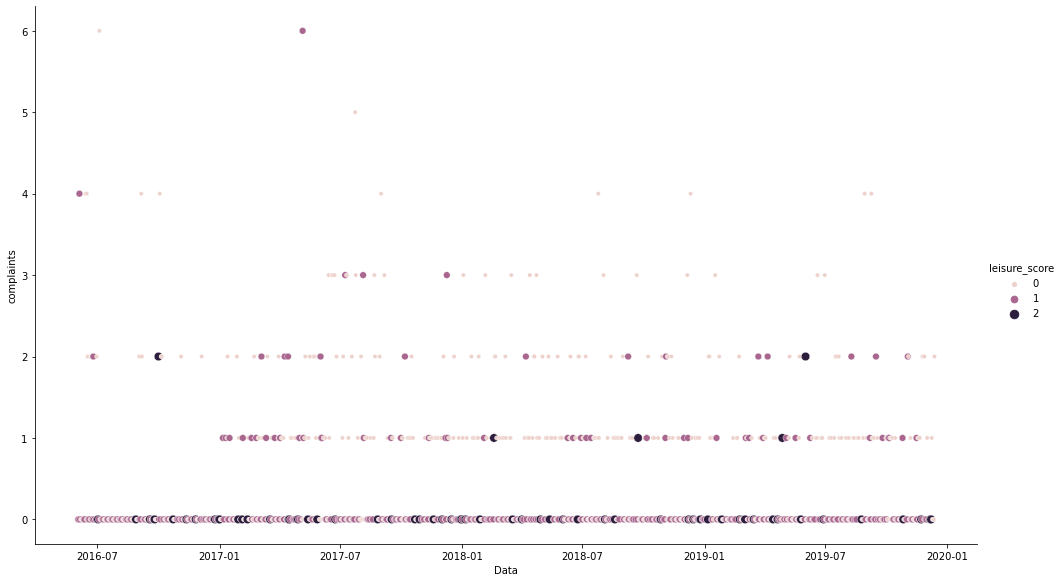

In [220]:
sns.relplot(x="Data", y="complaints", hue="leisure_score", size="leisure_score", data=df_leisure_day, height=8, aspect=1.7);

# CNN Prediction model

## First we generate our features

In [221]:
def generate_features(df, cols, distance=1, count_before=3, offset=0):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance+offset)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance+offset
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = math.floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[train.columns[4:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["noise_peaks"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[test.columns[4:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["noise_peaks"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

## Time series model parameters
* We are going to create 3 models:
    - 1) To predict up to one week (7 days) ahead of time
    - 2) To predict up to one month (30 days) ahead of time
    - 3) To predict up to one year (365 days) ahead of time

In [222]:
prediction_offset_params={
    7: [[1, 7], [1, 14], [1, 30], [7, 4], [7, 8], [7, 12]], #1 WEEK PREDICTION PARAMS
    30: [[1, 7], [1, 14], [1, 30], [7, 4], [7, 8], [7, 12]], #1 MONTH PREDICTION PARAMS
    365: [[1, 7], [1, 14], [1, 30], [7, 4], [7, 8], [7, 12]], #1 YEAR PREDICTION PARAMS
}

results= {
    7: None,
    30: None,
    365: None
}

## Train model

In [247]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, epochs, batch_size):
    verbose=0
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10, epochs=10, batch_size=32):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy, epochs, batch_size)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

## Hyperparameter optimization

In [245]:
def get_best_hyperparameter(trainX, trainy, testy, hyperparameter, hyperparameter_values):
    best_batch_size=None
    best_score=None
    for value in hyperparameter_values:
        print("{} = {}".format(str(hyperparameter), str(value)))
        args={hyperparameter: value}
        model, scores = run_experiment(trainX, trainy, testX, testy, repeats=5, **args)
        min_score=min(scores)
        if best_score is None or min_score<best_score:
            best_score=min_score
            best_batch_size=value
            
        print("Best Value: {}; Min MSE: {}".format(best_batch_size, best_score))
        print()
    return best_batch_size

In [238]:
df_features=generate_features(
    df_leisure_day, 
    ["noise_peaks", "leisure_score"], 
    distance=7, 
    count_before=4, 
    offset=7
)

train, test = split_df(df_features)
trainX, trainy, testX, testy = process_df(train, test)

#### Batch size

In [248]:
batch_sizes=[4, 8, 16, 32, 64]

best_batch_size=get_best_hyperparameter(trainX, trainy, testy, "batch_size", batch_sizes)

print("BEST BATCH SIZE: {}".format(best_batch_size))    

batch_size = 4
Train #0....
4
Train #1....
4
Train #2....
4
Train #3....
4
Train #4....
4
Best Value: 4; Min MSE: 2.7153406143188477

batch_size = 8
Train #0....
8
Train #1....
8
Train #2....
8
Train #3....
8
Train #4....
8
Best Value: 4; Min MSE: 2.7153406143188477

batch_size = 16
Train #0....
16
Train #1....
16
Train #2....
16
Train #3....
16
Train #4....
16
Best Value: 4; Min MSE: 2.7153406143188477

batch_size = 32
Train #0....
32
Train #1....
32
Train #2....
32
Train #3....
32
Train #4....
32
Best Value: 4; Min MSE: 2.7153406143188477

batch_size = 64
Train #0....
64
Train #1....
64
Train #2....
64
Train #3....
64
Train #4....
64
Best Value: 64; Min MSE: 2.684469223022461

BEST BATCH SIZE: 64


#### Epochs

In [249]:
epochs={5, 10, 20}

best_n_epochs=get_best_hyperparameter(trainX, trainy, testy, "epochs", epochs)

print("BEST NUMBER OF EPOCHS: {}".format(best_n_epochs))   

epochs = 10
Train #0....
32
Train #1....
32
Train #2....
32
Train #3....
32
Train #4....
32
Best Value: 10; Min MSE: 2.6834213733673096

epochs = 20
Train #0....
32
Train #1....
32
Train #2....
32
Train #3....
32
Train #4....
32
Best Value: 10; Min MSE: 2.6834213733673096

epochs = 5
Train #0....
32
Train #1....
32
Train #2....
32
Train #3....
32
Train #4....
32
Best Value: 10; Min MSE: 2.6834213733673096

BEST NUMBER OF EPOCHS: 10


## Time series parameter optimization
- We generate a model for each of the defined parameters 
- We split our data into train and test (80% train 20% test)
- We choose the best model for each prediction time (7, 30, 365)

In [ ]:
for offset, confs in prediction_offset_params.items():
    for params in confs:
        distance=params[0]
        count=params[1]
        
        print("TRAIN WITH OFFSET = {} AND DISTANCE = {} AND COUNT = {}".format(offset, distance, count))
        
        df_features=generate_features(
            df_leisure_day, 
            ["noise_peaks", "leisure_score"], 
            distance=distance, 
            count_before=count, 
            offset=offset
        )
        
        train, test = split_df(df_features)
        trainX, trainy, testX, testy = process_df(train, test)

        #print("Train X shape: " + str(trainX.shape))
        #print("Train Y shape: " + str(trainy.shape))

        #print("Test X shape: " + str(testX.shape))
        #print("Test Y shape: " + str(testy.shape))

        model, scores = run_experiment(trainX, trainy, testX, testy, repeats=5)
        
        print ("Train scores MSE scores (Prediction time (offset): {}, Distance: {}, Count: {})>> {}".format(offset, distance, count, str(scores)))
        
        min_score=min(scores)
        
        if results[offset] is None or min_score<results[offset]["best_score"]:
            results[offset]= {
                "best_score": min_score,
                "distance": distance,
                "count": count,
                "model": model,
                "test": test,
                "testX": testX,
                "testy": testy
            }
            
        print()

## Evaluate best models on the test set

BEST MODEL TO PREDICT UP TO 7 DAYS HEAD OF TIME
COUNT: 4
DISTANCE: 7
Root Mean Squared Error >> 1.6251882679980176

BEST MODEL TO PREDICT UP TO 30 DAYS HEAD OF TIME
COUNT: 7
DISTANCE: 1
Root Mean Squared Error >> 1.7047704029129125

BEST MODEL TO PREDICT UP TO 365 DAYS HEAD OF TIME
COUNT: 14
DISTANCE: 1
Root Mean Squared Error >> 1.4060277439749072



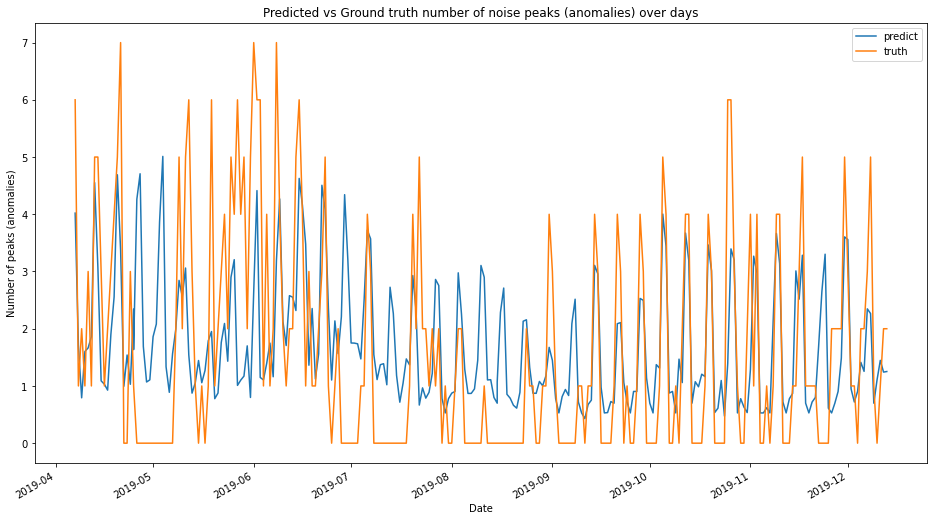

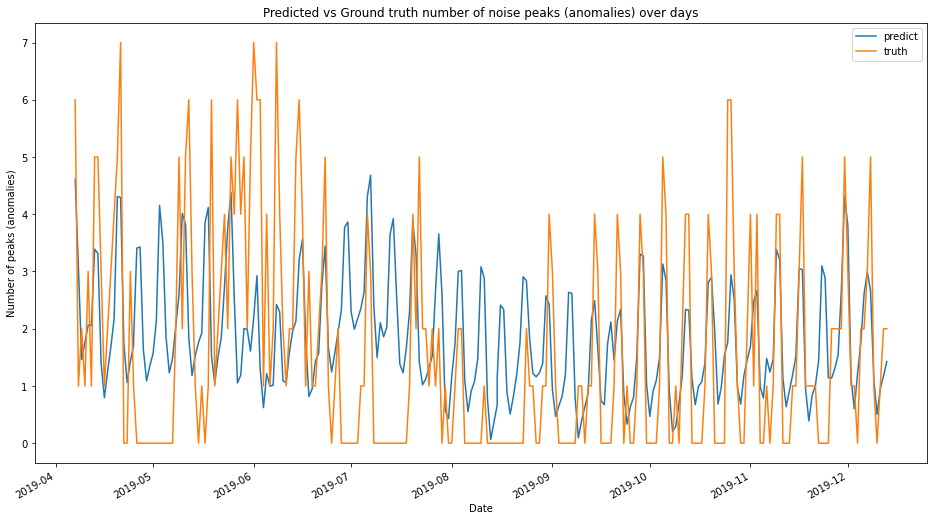

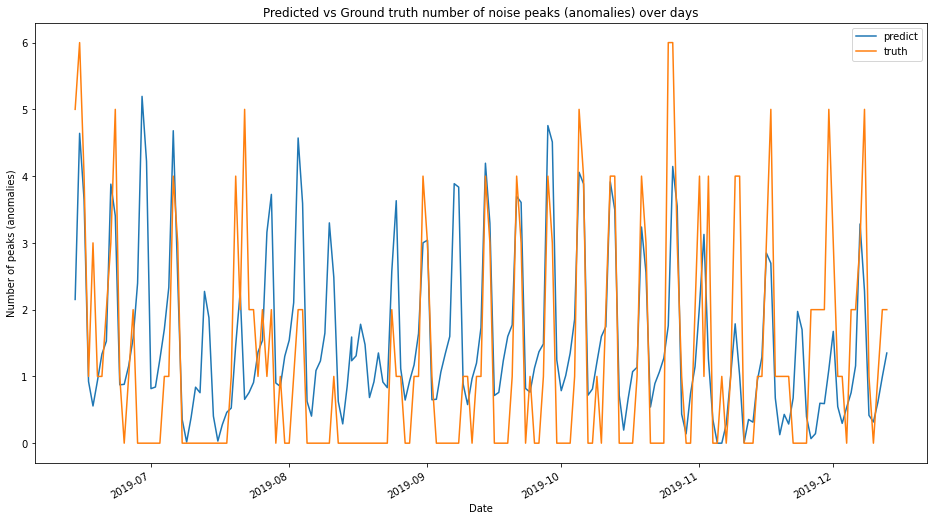

In [230]:
for offset, result in results.items():
    print("BEST MODEL TO PREDICT UP TO {} DAYS HEAD OF TIME".format(str(offset)))
    print("COUNT: {}".format(str(result["count"])))
    print("DISTANCE: {}".format(str(result["distance"])))
    testX=result["testX"]
    testy=result["testy"]
    test=result["test"]
    model=result["model"]
    
    predict = model.predict(testX)
    dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
    truth=pd.DataFrame(data=testy[:], columns=["truth"])
    testDf=pd.concat([dfPredict, truth, test.reset_index()[["Data"]]], axis=1)

    rms = np.sqrt(mean_squared_error(testDf["truth"], testDf["predict"]))
    print ("Root Mean Squared Error >> " + str(rms))
    testDf.reset_index()
    ax=testDf.plot(x="Data", figsize=(16,9), title='Predicted vs Ground truth number of noise peaks (anomalies) over days')

    ax.set_xlabel("Date")
    ax.set_ylabel("Number of peaks (anomalies)")
    plt.plot()
    print()